## 1. Import Library

In [1]:
# Basic Library
import pandas as pd
import numpy as np
import os

# Preprocessing
from sklearn.preprocessing import OneHotEncoder

# HP Tuning
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour, plot_optimization_history
from optuna.visualization import plot_parallel_coordinate, plot_slice, plot_param_importances

# Modeling
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss
import tensorflow as tf
import keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## 2. Import Data

In [2]:
train = pd.read_csv("D:/_data/dacon/hand_gesture_data/train.csv")
test = pd.read_csv("D:/_data/dacon/hand_gesture_data/test.csv")
submission = pd.read_csv("D:/_data/dacon/hand_gesture_data/sample_submission.csv")

## 3. CNN Modeling

### (1) HP Tuning

In [3]:
train_x = train.iloc[:, 1:-1]
test_x = test.iloc[:, 1:]

train_x = np.array(train_x).reshape(-1, 8, 4, 1)
test_x = np.array(test_x).reshape(-1, 8, 4, 1)

ohe = OneHotEncoder(sparse = False)
train_y = ohe.fit_transform(train[['target']])

In [4]:
def create_model(num_layer, mid_units, num_filters):
    
    model = Sequential()
    model.add(Conv2D(filters=num_filters[0], kernel_size=(2, 2),
                 activation="elu",
                 input_shape=(8, 4, 1)))
    model.add(BatchNormalization())
    #model.add(Dropout(dropout_rate[0]))
    for i in range(1,num_layer):
        model.add(Conv2D(filters=num_filters[i], kernel_size=(2, 2), padding="same", activation="elu"))
        model.add(BatchNormalization())
        #model.add(Dropout(dropout_rate[i+1]))
            
    model.add(GlobalAveragePooling2D())
    model.add(Dense(mid_units, activation='relu'))
    #model.add(Dropout(dropout_rate[-1]))
    model.add(Dense(4, activation='softmax'))
    
    return model

In [5]:
def cnn_objective(trial: Trial) -> float:
    
    #clear_session
    keras.backend.clear_session()
    
    #number of the convolution layer
    num_layer = trial.suggest_int("num_layer", 2, 3)
    
    #number of the unit
    mid_units = int(trial.suggest_discrete_uniform("mid_units", 30, 150, 10))
    
    #number of the each convolution layer filter
    num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]

    #Dropout
    #dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    #dropout_rate = [int(trial.suggest_uniform("dropout_rate"+str(ii), 0.0, 0.5)) for ii in range(num_layer+1)]
    
        
    seed = 42
    kfold = StratifiedKFold(n_splits=5, random_state = seed, shuffle = True) # Cross-validation cv=5
    es = EarlyStopping(monitor="val_acc", patience=5, mode="max", verbose=0)
    cv = np.zeros((train_x.shape[0], 4))

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train.target)):

        x_train, y_train = train_x[train_idx], train_y[train_idx]
        x_val, y_val = train_x[val_idx], train_y[val_idx]
        
        mc = ModelCheckpoint(f"model_{n+1}.h5", save_best_only=True, monitor="val_acc", mode="max", verbose=0)
        
        model = create_model(num_layer, mid_units, num_filters)
        
        # Adam optimizer learning rate
        optimizer = Adam(learning_rate=trial.suggest_uniform("learning_rate", 0.0005, 0.005))
        model.compile(optimizer=optimizer,
                      loss="categorical_crossentropy",
                      metrics=["acc"])
        model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, 
                  callbacks=[es,mc], verbose=None)
        
        best = load_model(f"model_{n+1}.h5")
        
        cv[val_idx, :] = best.predict(x_val)
        
    print('multi_logloss:', log_loss(train_y, cv))
    print('accuracy_score:', accuracy_score(np.argmax(train_y, axis=1), np.argmax(cv, axis=1)))

    
    return accuracy_score(np.argmax(train_y, axis=1), np.argmax(cv, axis=1))

In [6]:
sampler = TPESampler(seed=42)
cnn_study = optuna.create_study(study_name="cnn_parameter_opt", direction="maximize", sampler=sampler)
cnn_study.optimize(cnn_objective, n_trials=20)

[I 2022-03-16 00:09:34,995] A new study created in memory with name: cnn_parameter_opt
[I 2022-03-16 00:10:19,402] Trial 0 finished with value: 0.867237687366167 and parameters: {'num_layer': 2, 'mid_units': 150.0, 'num_filter_0': 192.0, 'num_filter_1': 160.0, 'learning_rate': 0.0012020838819909643}. Best is trial 0 with value: 0.867237687366167.


multi_logloss: 0.36963855168650284
accuracy_score: 0.867237687366167


[I 2022-03-16 00:10:44,516] Trial 1 finished with value: 0.8650963597430407 and parameters: {'num_layer': 2, 'mid_units': 30.0, 'num_filter_0': 224.0, 'num_filter_1': 160.0, 'learning_rate': 0.003686326600082205}. Best is trial 0 with value: 0.867237687366167.


multi_logloss: 0.39319038466156503
accuracy_score: 0.8650963597430407


[I 2022-03-16 00:11:14,079] Trial 2 finished with value: 0.8753747323340471 and parameters: {'num_layer': 2, 'mid_units': 150.0, 'num_filter_0': 224.0, 'num_filter_1': 64.0, 'learning_rate': 0.001318212352431953}. Best is trial 2 with value: 0.8753747323340471.


multi_logloss: 0.3821079551905093
accuracy_score: 0.8753747323340471


[I 2022-03-16 00:11:45,702] Trial 3 finished with value: 0.8693790149892934 and parameters: {'num_layer': 2, 'mid_units': 60.0, 'num_filter_0': 144.0, 'num_filter_1': 112.0, 'learning_rate': 0.0018105311308911887}. Best is trial 2 with value: 0.8753747323340471.


multi_logloss: 0.3826206180531082
accuracy_score: 0.8693790149892934


[I 2022-03-16 00:12:10,816] Trial 4 finished with value: 0.8599571734475375 and parameters: {'num_layer': 3, 'mid_units': 40.0, 'num_filter_0': 80.0, 'num_filter_1': 96.0, 'num_filter_2': 128.0, 'learning_rate': 0.004033291826268562}. Best is trial 2 with value: 0.8753747323340471.


multi_logloss: 0.4117440010984796
accuracy_score: 0.8599571734475375


[I 2022-03-16 00:12:35,681] Trial 5 finished with value: 0.8668094218415417 and parameters: {'num_layer': 2, 'mid_units': 90.0, 'num_filter_0': 160.0, 'num_filter_1': 16.0, 'learning_rate': 0.003233951833556473}. Best is trial 2 with value: 0.8753747323340471.


multi_logloss: 0.4042746665565178
accuracy_score: 0.8668094218415417


[I 2022-03-16 00:13:05,750] Trial 6 finished with value: 0.8685224839400428 and parameters: {'num_layer': 2, 'mid_units': 30.0, 'num_filter_0': 256.0, 'num_filter_1': 256.0, 'learning_rate': 0.004137788066524076}. Best is trial 2 with value: 0.8753747323340471.


multi_logloss: 0.3820161553762511
accuracy_score: 0.8685224839400428


[I 2022-03-16 00:13:34,520] Trial 7 finished with value: 0.8706638115631692 and parameters: {'num_layer': 2, 'mid_units': 40.0, 'num_filter_0': 176.0, 'num_filter_1': 128.0, 'learning_rate': 0.0010491720568015048}. Best is trial 2 with value: 0.8753747323340471.


multi_logloss: 0.3714855650622875
accuracy_score: 0.8706638115631692


[I 2022-03-16 00:14:00,143] Trial 8 finished with value: 0.8702355460385439 and parameters: {'num_layer': 2, 'mid_units': 30.0, 'num_filter_0': 240.0, 'num_filter_1': 80.0, 'learning_rate': 0.0034813502795929194}. Best is trial 2 with value: 0.8753747323340471.


multi_logloss: 0.380870634684188
accuracy_score: 0.8702355460385439


[I 2022-03-16 00:14:23,993] Trial 9 finished with value: 0.8659528907922912 and parameters: {'num_layer': 2, 'mid_units': 90.0, 'num_filter_0': 144.0, 'num_filter_1': 48.0, 'learning_rate': 0.004863130824940514}. Best is trial 2 with value: 0.8753747323340471.


multi_logloss: 0.38168729799759815
accuracy_score: 0.8659528907922912


[I 2022-03-16 00:14:50,955] Trial 10 finished with value: 0.860813704496788 and parameters: {'num_layer': 3, 'mid_units': 150.0, 'num_filter_0': 16.0, 'num_filter_1': 224.0, 'num_filter_2': 256.0, 'learning_rate': 0.0022113183211331486}. Best is trial 2 with value: 0.8753747323340471.


multi_logloss: 0.41866427124551375
accuracy_score: 0.860813704496788


[I 2022-03-16 00:15:23,204] Trial 11 finished with value: 0.8650963597430407 and parameters: {'num_layer': 3, 'mid_units': 120.0, 'num_filter_0': 192.0, 'num_filter_1': 144.0, 'num_filter_2': 16.0, 'learning_rate': 0.000543332919286302}. Best is trial 2 with value: 0.8753747323340471.


multi_logloss: 0.39074892138568523
accuracy_score: 0.8650963597430407


[I 2022-03-16 00:15:58,871] Trial 12 finished with value: 0.8689507494646681 and parameters: {'num_layer': 2, 'mid_units': 120.0, 'num_filter_0': 96.0, 'num_filter_1': 64.0, 'learning_rate': 0.000553846717369572}. Best is trial 2 with value: 0.8753747323340471.


multi_logloss: 0.37501467152519463
accuracy_score: 0.8689507494646681


[I 2022-03-16 00:16:30,142] Trial 13 finished with value: 0.8749464668094219 and parameters: {'num_layer': 2, 'mid_units': 60.0, 'num_filter_0': 192.0, 'num_filter_1': 192.0, 'learning_rate': 0.001583635718754096}. Best is trial 2 with value: 0.8753747323340471.


multi_logloss: 0.3627211978492796
accuracy_score: 0.8749464668094219


[I 2022-03-16 00:17:05,958] Trial 14 finished with value: 0.8620985010706638 and parameters: {'num_layer': 3, 'mid_units': 70.0, 'num_filter_0': 208.0, 'num_filter_1': 208.0, 'num_filter_2': 256.0, 'learning_rate': 0.002227364168795375}. Best is trial 2 with value: 0.8753747323340471.


multi_logloss: 0.42457641512232003
accuracy_score: 0.8620985010706638


[I 2022-03-16 00:17:35,554] Trial 15 finished with value: 0.8762312633832976 and parameters: {'num_layer': 2, 'mid_units': 110.0, 'num_filter_0': 112.0, 'num_filter_1': 192.0, 'learning_rate': 0.001576915818593446}. Best is trial 15 with value: 0.8762312633832976.


multi_logloss: 0.3683714315708182
accuracy_score: 0.8762312633832976


[I 2022-03-16 00:18:01,369] Trial 16 finished with value: 0.8689507494646681 and parameters: {'num_layer': 2, 'mid_units': 120.0, 'num_filter_0': 112.0, 'num_filter_1': 16.0, 'learning_rate': 0.002586491129747755}. Best is trial 15 with value: 0.8762312633832976.


multi_logloss: 0.36463355056570573
accuracy_score: 0.8689507494646681


[I 2022-03-16 00:18:26,528] Trial 17 finished with value: 0.8732334047109208 and parameters: {'num_layer': 3, 'mid_units': 130.0, 'num_filter_0': 48.0, 'num_filter_1': 176.0, 'num_filter_2': 32.0, 'learning_rate': 0.0012981153573238232}. Best is trial 15 with value: 0.8762312633832976.


multi_logloss: 0.37637088530046614
accuracy_score: 0.8732334047109208


[I 2022-03-16 00:18:53,373] Trial 18 finished with value: 0.8723768736616703 and parameters: {'num_layer': 2, 'mid_units': 140.0, 'num_filter_0': 112.0, 'num_filter_1': 256.0, 'learning_rate': 0.0018952461739508682}. Best is trial 15 with value: 0.8762312633832976.


multi_logloss: 0.36508908017453734
accuracy_score: 0.8723768736616703


[I 2022-03-16 00:19:23,213] Trial 19 finished with value: 0.8710920770877945 and parameters: {'num_layer': 2, 'mid_units': 90.0, 'num_filter_0': 64.0, 'num_filter_1': 48.0, 'learning_rate': 0.0028560792229865035}. Best is trial 15 with value: 0.8762312633832976.


multi_logloss: 0.35829051112947385
accuracy_score: 0.8710920770877945


### (2) Visualization

C:\Users\bitcamp\AppData\Local\Temp/ipykernel_9552/1430751235.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(cnn_study);


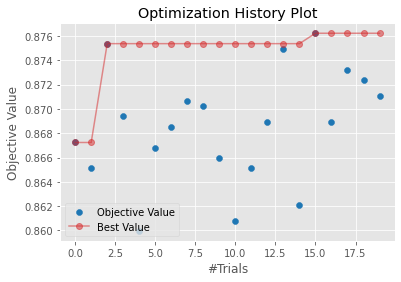

In [7]:
optuna.visualization.matplotlib.plot_optimization_history(cnn_study);

C:\Users\bitcamp\AppData\Local\Temp/ipykernel_9552/3633289961.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(cnn_study);


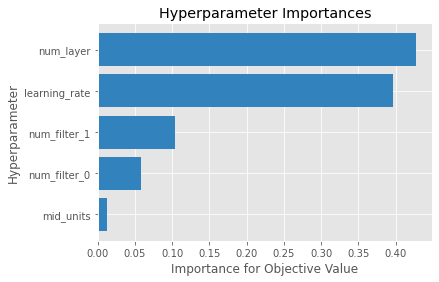

In [8]:
optuna.visualization.matplotlib.plot_param_importances(cnn_study);

C:\Users\bitcamp\AppData\Local\Temp/ipykernel_9552/3328840784.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(cnn_study);


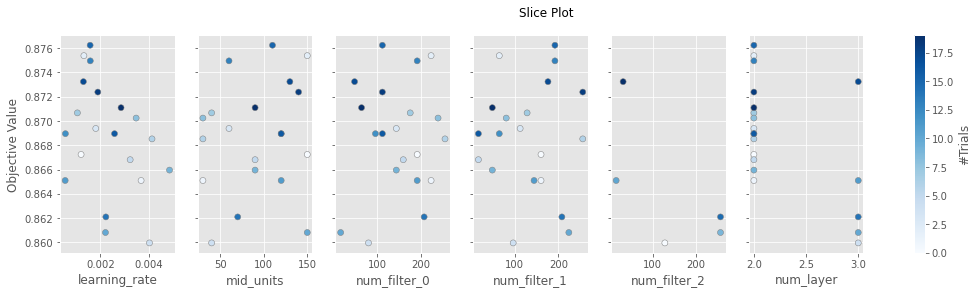

In [9]:
optuna.visualization.matplotlib.plot_slice(cnn_study);

### (3) Training

In [10]:
cnn_acc = []
cnn_pred = np.zeros((test_x.shape[0], 4))
seed = 42
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
es = EarlyStopping(monitor="val_acc", patience=5, mode="max", verbose=0)

for i, (train_idx, val_idx) in enumerate(skf.split(train_x, train.target)):
    print(f"{i+1} Fold Training.....")
    x_train, y_train = train_x[train_idx], train_y[train_idx]
    x_val, y_val = train_x[val_idx], train_y[val_idx]
    
    cnn = create_model(cnn_study.best_params['num_layer'], cnn_study.best_params['mid_units'], 
                      [cnn_study.best_params[f'num_filter_{i}'] for i in range(cnn_study.best_params['num_layer'])])
    
    # ModelCheckpoint Fold마다 갱신
    mc = ModelCheckpoint(f"model_{i+1}.h5", save_best_only=True, monitor="val_acc", mode="max", verbose=0)
    
    # 모델 Complie
    optimizer = Adam(learning_rate=cnn_study.best_params['learning_rate'])
    cnn.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"])
    cnn.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, callbacks=[es,mc], verbose=0)
    
    # 최고 성능 기록 모델
    best = load_model(f"model_{i+1}.h5")
    
    val_pred = best.predict(x_val)
    
    val_cls = np.argmax(val_pred, axis=1)
    
    fold_cnn_acc = accuracy_score(np.argmax(y_val, axis=1), val_cls)
    cnn_acc.append(fold_cnn_acc)
    print(f"{i+1} Fold ACC of CNN = {fold_cnn_acc}\n")
    
    fold_pred = best.predict(test_x) / skf.n_splits
    cnn_pred += fold_pred

1 Fold Training.....
1 Fold ACC of CNN = 0.8586723768736617

2 Fold Training.....
2 Fold ACC of CNN = 0.9036402569593148

3 Fold Training.....
3 Fold ACC of CNN = 0.867237687366167

4 Fold Training.....
4 Fold ACC of CNN = 0.8715203426124197

5 Fold Training.....
5 Fold ACC of CNN = 0.8715203426124197



In [11]:
np.mean(cnn_acc)

0.8745182012847966

## 5. Submission

In [12]:
submission['target'] = np.argmax(cnn_pred, axis = 1)
submission.to_csv('D:/Study/hackarthon/hands/submission.csv', index = False)
submission.target.value_counts()

3    2341
0    2339
2    2333
1    2330
Name: target, dtype: int64